In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('fivethirtyeight')

In [64]:
from sklearn.base import TransformerMixin
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures

In [3]:
X = pd.DataFrame({'city':['tokyo', None, 'london', 'seattle', 'san francisco', 'tokyo'], 
                  'boolean':['yes', 'no', None, 'no', 'no', 'yes'], 
                  'ordinal_column':['somewhat like', 'like', 'somewhat like', 'like', 'somewhat like', 'dislike'], 
                  'quantitative_column':[1, 11, -.5, 10, None, 20]})

In [4]:
X

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,None,like,11.0
2,None,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,20.0


In [7]:
X.isnull().sum()

boolean                1
city                   1
ordinal_column         0
quantitative_column    1
dtype: int64

In [10]:
X.city.value_counts().index[0]

'tokyo'

In [28]:
# create custom dummifier

class CustomDummifier(TransformerMixin):
    
    def __init__(self, cols=None):
        self.cols = cols
        
    def fit(self, *_):
        return self
    
    def transform(self, X):
        return pd.get_dummies(X, columns=self.cols)

In [5]:
class CustomCategoryImputer(TransformerMixin):
    
    def __init__(self, cols=None):
        self.cols = cols
        
    def fit(self, *_):
        return self
    
    def transform(self, df):
        X = df.copy()
        for col in self.cols:
            X[col].fillna(X[col].value_counts().index[0], # fill na with the mode
                          inplace=True)
        return X
    
class CustomQuantitativeImputer(TransformerMixin):
    
    def __init__(self, cols=None, strategy=''):
        self.cols = cols
        self.strategy = strategy
        
    def fit(self, *_):
        return self
    
    def transform(self, df):
        X = df.copy()
        imputer = Imputer(strategy=self.strategy)
        for col in self.cols:
            X[col] = imputer.fit_transform(X[[col]])
        return X

In [6]:
cci = CustomCategoryImputer(['boolean', 'city'])
cqi = CustomQuantitativeImputer(['quantitative_column'], 'mean')

In [7]:
cci.fit_transform(cqi.fit_transform(X))

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,tokyo,like,11.0
2,no,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,8.3
5,yes,tokyo,dislike,20.0


In [8]:
imputer = Pipeline([
    ('cqi', CustomQuantitativeImputer(['quantitative_column'], 'mean')),
    ('cci', CustomCategoryImputer(['boolean', 'city'])),
])

In [9]:
imputer.fit_transform(X)

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,tokyo,like,11.0
2,no,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,8.3
5,yes,tokyo,dislike,20.0


In [10]:
imputer.transform(X)

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,1.0
1,no,tokyo,like,11.0
2,no,london,somewhat like,-0.5
3,no,seattle,like,10.0
4,no,san francisco,somewhat like,8.3
5,yes,tokyo,dislike,20.0


#### Encoding categorical variables

In [11]:
pd.get_dummies(X, columns=['boolean', 'city'], drop_first=True)

,ordinal_column,quantitative_column,boolean_yes,city_san francisco,city_seattle,city_tokyo
0,somewhat like,1.0,1,0,0,1
1,like,11.0,0,0,0,0
2,somewhat like,-0.5,0,0,0,0
3,like,10.0,0,0,1,0
4,somewhat like,NaN,0,1,0,0
5,dislike,20.0,1,0,0,1


#### Encoding at the ordinal level

In [12]:
ordering = ['dislike', 'somewhat like', 'like']

In [13]:
X['ordinal_column'].map(ordering.index)

0    1
1    2
2    1
3    2
4    1
5    0
Name: ordinal_column, dtype: int64

In [14]:
class CustomEncoder(TransformerMixin):
    
    def __init__(self, col, ordering):
        self.col = col
        self.ordering = ordering
        
    def fit(self, *_):
        return self

    def transform(self, df):
        X = df.copy()
        X[self.col] = X[self.col].map(self.ordering.index)
        return X

In [15]:
ce = CustomEncoder('ordinal_column', ordering)
ce.fit_transform(X)

,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,1,1.0
1,no,None,2,11.0
2,None,london,1,-0.5
3,no,seattle,2,10.0
4,no,san francisco,1,NaN
5,yes,tokyo,0,20.0


#### Bucketing numerical into categorical column

In [16]:
pd.cut(X['quantitative_column'], bins=3, retbins=True, labels=False)

(0    0.0
 1    1.0
 2    0.0
 3    1.0
 4    NaN
 5    2.0
 Name: quantitative_column, dtype: float64,
 array([-0.5205    ,  6.33333333, 13.16666667, 20.        ]))

In [21]:
class CustomCutter(TransformerMixin):
    
    def __init__(self, column, bins, labels=False):
        self.col = column
        self.bins = bins
        self.labels = labels
        
    def fit(self, *_):
        return self
    
    def transform(self, df):
        X = df.copy()
        if isinstance(self.bins, int):
            print('first time fit')
            X[self.col], self.bins = pd.cut(X[self.col], self.bins, 
                                            retbins=True, labels=self.labels)
        else:
            print('already fitted')
            X[self.col] = pd.cut(X[self.col], self.bins, 
                                 retbins=False, labels=self.labels)
        return X

In [22]:
cc = CustomCutter('quantitative_column', bins=3)

In [23]:
cc.fit_transform(X)

first time fit


,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,0.0
1,no,None,like,1.0
2,None,london,somewhat like,0.0
3,no,seattle,like,1.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,2.0


In [24]:
cc.transform(X)

already fitted


,boolean,city,ordinal_column,quantitative_column
0,yes,tokyo,somewhat like,0.0
1,no,None,like,1.0
2,None,london,somewhat like,0.0
3,no,seattle,like,1.0
4,no,san francisco,somewhat like,NaN
5,yes,tokyo,dislike,2.0


In [25]:
cc.bins

array([-0.5205    ,  6.33333333, 13.16666667, 20.        ])

In [26]:
np.unique(X['quantitative_column'], return_counts=True)

(array([-0.5,  1. , 10. , 11. , 20. ,  nan]),
 array([1, 1, 1, 1, 1, 1], dtype=int64))

In [27]:
pd.value_counts(X['quantitative_column']).max()

1

In [34]:
imputer = Pipeline([
    ('cat_imp', CustomCategoryImputer(cols=['boolean', 'city'])),
    ('quan_imp', CustomQuantitativeImputer(cols=['quantitative_column'], strategy='mean'))
])

In [36]:
pipe = Pipeline([
    ('imputer', imputer),
    ('dummifier', CustomDummifier(cols=['boolean', 'city'])),
    ('label_encoder', CustomEncoder(col='ordinal_column', ordering=['dislike', 'somewhat like', 'like'])),
    ('bin_cutter', CustomCutter('quantitative_column', bins=3)),
])

In [37]:
pipe.fit_transform(X)

first time fit


,ordinal_column,quantitative_column,boolean_no,boolean_yes,city_london,city_san francisco,city_seattle,city_tokyo
0,1,0,0,1,0,0,0,1
1,2,1,1,0,0,0,0,1
2,1,0,1,0,1,0,0,0
3,2,1,1,0,0,0,1,0
4,1,1,1,0,0,1,0,0
5,0,2,0,1,0,0,0,1


#### Extending numerical features

In [40]:
df = pd.read_csv('data/activity_recognizer/1.csv', header=None, 
                 names=['index', 'x', 'y', 'z', 'activity'])

In [42]:
df.nunique()

index       106251
x              499
y              557
z              485
activity         8
dtype: int64

In [43]:
df.head()

,index,x,y,z,activity
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


In [46]:
df.describe()

,index,x,y,z,activity
count,162501.000000,162501.000000,162501.000000,162501.000000,162501.000000
mean,81250.000000,1910.670857,2380.286367,2041.214829,4.899681
std,46910.142472,40.653208,41.925728,59.529406,2.424311
min,0.000000,1455.000000,1697.000000,1644.000000,0.000000
25%,40625.000000,1886.000000,2374.000000,1991.000000,3.000000
50%,81250.000000,1905.000000,2381.000000,2022.000000,7.000000
75%,121880.000000,1935.000000,2386.000000,2101.000000,7.000000
max,162500.000000,2356.000000,2713.000000,2739.000000,7.000000


In [45]:
'''
activity
--------
1: working at a computer
2: standing up and going updown stairs
3: standing
4: walking
5: going updown stairs
6: walking and talking with someone
7: talking while standing
'''

# baseline accuracy = 0.515 if we predict 7 everytime
df.activity.value_counts(normalize=True)

7    0.515369
1    0.207242
4    0.165291
3    0.068793
5    0.019637
6    0.017951
2    0.005711
0    0.000006
Name: activity, dtype: float64

In [50]:
# could be missing value -> drop the row
df.query('activity==0')

,index,x,y,z,activity
162500,162500.0,1922,2387,2078,0


In [53]:
df.drop(index=162500, inplace=True)

In [54]:
df.shape

(162500, 5)

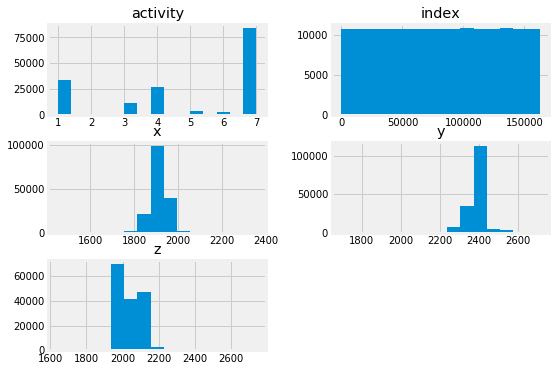

In [57]:
'''
data level:
----------

x, y, z -> interval()
activity -> nominal
'''

_ = df.hist(bins=15, figsize=(8, 6))

In [59]:
X = df[['x', 'y', 'z']]
y = df['activity']

X.shape, y.shape

((162500, 3), (162500,))

In [60]:
knn_grid = GridSearchCV(KNeighborsClassifier(), 
                        param_grid={'n_neighbors': [3,4,5,6]})

knn_grid.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 4, 5, 6]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [61]:
knn_grid.best_score_, knn_grid.best_params_

(0.72072, {'n_neighbors': 5})

In [62]:
knn_grid.cv_results_['mean_test_score']

array([0.70846769, 0.70318769, 0.72072   , 0.71569846])

#### Polynomial features

In [65]:
poly = PolynomialFeatures(degree=2, 
                          interaction_only=False, 
                          include_bias=False)

In [66]:
X_poly = poly.fit_transform(X)
X_poly.shape

(162500, 9)

In [67]:
poly.get_feature_names()

['x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']

In [68]:
pd.DataFrame(X_poly, columns=poly.get_feature_names()).head()

,x0,x1,x2,x0^2,x0 x1,x0 x2,x1^2,x1 x2,x2^2
0,1502.0,2215.0,2153.0,2256004.0,3326930.0,3233806.0,4906225.0,4768895.0,4635409.0
1,1667.0,2072.0,2047.0,2778889.0,3454024.0,3412349.0,4293184.0,4241384.0,4190209.0
2,1611.0,1957.0,1906.0,2595321.0,3152727.0,3070566.0,3829849.0,3730042.0,3632836.0
3,1601.0,1939.0,1831.0,2563201.0,3104339.0,2931431.0,3759721.0,3550309.0,3352561.0
4,1643.0,1965.0,1879.0,2699449.0,3228495.0,3087197.0,3861225.0,3692235.0,3530641.0


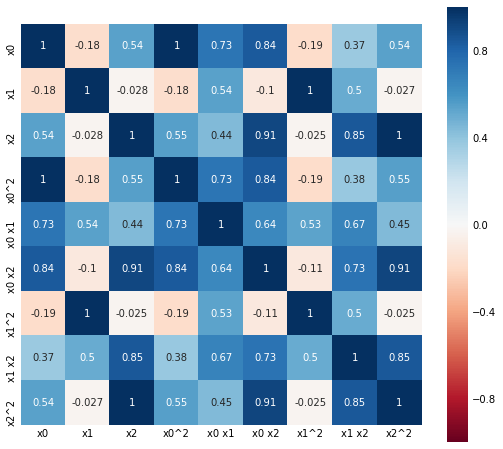

In [70]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr(), 
            square=True, annot=True, ax=ax, cmap=plt.cm.RdBu, vmax=1, vmin=-1)

In [71]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X_poly = poly.fit_transform(X)

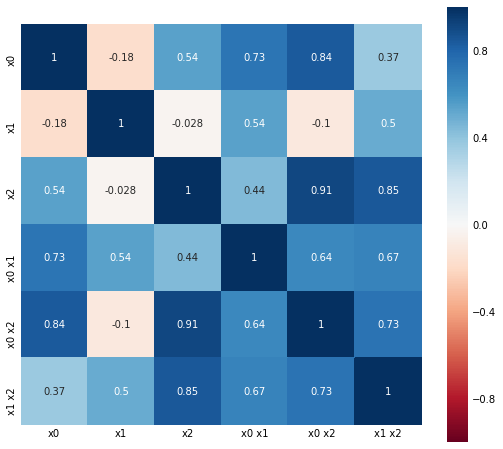

In [73]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(pd.DataFrame(X_poly, columns=poly.get_feature_names()).corr(), 
            square=True, annot=True, ax=ax, cmap=plt.cm.RdBu, vmax=1, vmin=-1)

In [74]:
pipe = Pipeline([
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('classifier', KNeighborsClassifier()),
])

params = {
    'poly_features__degree': [1,2,3],
    'poly_features__interaction_only': [True, False],
    'classifier__n_neighbors': [3,4,5,6],
}

grid = GridSearchCV(pipe, params)
grid.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'classifier__n_neighbors': [3, 4, 5, 6], 'poly_features__degree': [1, 2, 3], 'poly_features__interaction_only': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [75]:
grid.best_score_, grid.best_params_

(0.7212184615384616,
 {'classifier__n_neighbors': 5,
  'poly_features__degree': 2,
  'poly_features__interaction_only': True})

#### Text-specific feature construction

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer

In [76]:
tweets = pd.read_csv('data/twitter_sentiment.csv', encoding='latin1')

In [77]:
tweets.shape

(99989, 3)

In [79]:
tweets.drop('ItemID', axis=1, inplace=True)

In [80]:
tweets.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [82]:
X = tweets['SentimentText']
y = tweets['Sentiment']

X.shape, y.shape

((99989,), (99989,))

In [83]:
# default
vect = CountVectorizer()
_ = vect.fit_transform(X)

_.shape

(99989, 105849)

In [85]:
# with english stopword
vect = CountVectorizer(stop_words='english')
_ = vect.fit_transform(X)
_.shape

(99989, 105545)

In [87]:
# with min_df
vect = CountVectorizer(min_df=100)
_ = vect.fit_transform(X)
_.shape

(99989, 1076)

In [88]:
# with max_df
vect = CountVectorizer(max_df=.8)
_ = vect.fit_transform(X)
_.shape

(99989, 105849)

In [89]:
# with ngram_range 
vect = CountVectorizer(ngram_range=(1, 5), min_df=80)
_ = vect.fit_transform(X)
_.shape

(99989, 2550)

In [90]:
vect.get_feature_names()

['10',
 '100',
 '100 followers',
 '100 followers day',
 '100 followers day using',
 '100 followers day using www',
 '11',
 '12',
 '15',
 '1capplegate',
 '1st',
 '20',
 '24',
 '2day',
 '2nd',
 '30',
 '30secondstomars',
 '50',
 '_crc_',
 'able',
 'able to',
 'about',
 'about it',
 'about my',
 'about that',
 'about the',
 'about to',
 'about you',
 'about your',
 'absolutely',
 'account',
 'act',
 'actually',
 'adam',
 'add',
 'add everyone',
 'add everyone you',
 'add everyone you are',
 'add everyone you are on',
 'afraid',
 'after',
 'after the',
 'afternoon',
 'again',
 'against',
 'ago',
 'agree',
 'agree with',
 'agreed',
 'ah',
 'ahead',
 'ahh',
 'ahhh',
 'ain',
 'aint',
 'air',
 'airport',
 'alancarr',
 'album',
 'alex',
 'alexalltimelow',
 'alive',
 'all',
 'all day',
 'all good',
 'all is',
 'all my',
 'all of',
 'all over',
 'all that',
 'all the',
 'all the time',
 'allowed',
 'almost',
 'alone',
 'along',
 'alot',
 'already',
 'alright',
 'also',
 'although',
 'always',
 'al

In [92]:
stemmer = SnowballStemmer('english')

In [93]:
def word_tokenize(text):
    return [stemmer.stem(w) for w in text.split()]

In [94]:
word_tokenize('hello you are very interesting')

['hello', 'you', 'are', 'veri', 'interest']

In [97]:
# with analyzer
vect = CountVectorizer(analyzer=word_tokenize, stop_words='english', min_df=30)
_ = vect.fit_transform(X)
_.shape

(99989, 2880)

In [99]:
vect.get_feature_names()

['!',
 '!!',
 '!!!',
 '!!!!',
 '#',
 '#1',
 '#3turnoffword',
 '#asot400',
 '#bgt',
 '#bsb',
 '#dontyouh',
 '#f1',
 '#fail',
 '#fb',
 '#ff',
 '#flyladi',
 '#followfriday',
 '#goodsex',
 '#haveyouev',
 '#inaperfectworld',
 '#iphon',
 '#iranelect',
 '#irememb',
 '#musicmonday',
 '#myweak',
 '#squarespac',
 '$',
 '&amp;',
 '&amp;&amp;',
 '&gt;',
 '&lt;--',
 '&lt;---',
 '&lt;3',
 '&quot;',
 '&quot;a',
 '&quot;and',
 '&quot;i',
 "&quot;i'm",
 '&quot;if',
 '&quot;it',
 '&quot;mi',
 '&quot;th',
 '&quot;ther',
 '&quot;w',
 '&quot;you',
 "'s",
 '(',
 '(:',
 '(and',
 '(i',
 '(not',
 '(or',
 '(via',
 ')',
 '*',
 '*cries*',
 '*hugs*',
 '*sigh*',
 '*sighs*',
 '*yawn*',
 '+',
 ',',
 '-',
 '--',
 '.',
 '..',
 '...',
 '....',
 '.....',
 '...and',
 '...but',
 '...i',
 '..i',
 '/',
 '//',
 '1',
 '1/2',
 '10',
 '100',
 '100%',
 '11',
 '12',
 '14',
 '140',
 '15',
 '16',
 '18',
 '1st',
 '2',
 '2.',
 '20',
 '2009',
 '21',
 '24',
 '25',
 '2day',
 '2nd',
 '3',
 '3.0',
 '30',
 '3g',
 '3rd',
 '4',
 '4th',
 '5',


#### The Tf-idf vectorizer

In [107]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import FeatureUnion
from sklearn.naive_bayes import MultinomialNB

In [101]:
vect = CountVectorizer()
_ = vect.fit_transform(X)
print(_.shape)
print(_[0, :].mean())

(99989, 105849)
6.613194267305311e-05


In [102]:
vect = TfidfVectorizer()
_ = vect.fit_transform(X)
print(_.shape)
print(_[0, :].mean())

(99989, 105849)
2.1863060975751186e-05


In [104]:
# baseline accuracy
y.mean()

0.5646321095320486

In [105]:
# pipeline : countvectorizer -> multinomial_nb
pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB()),
])

params = {
    'vectorizer__max_features': [1000, 10000],
    'vectorizer__stop_words': [None, 'english'],
    'vectorizer__ngram_range': [(1,1), (1,2)],
}

grid = GridSearchCV(pipe, params)
grid.fit(X, y)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), prepro...one, vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'vectorizer__stop_words': [None, 'english'], 'vectorizer__max_features': [1000, 10000], 'vectorizer__ngram_range': [(1, 1), (1, 2)]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [106]:
grid.best_score_, grid.best_params_

(0.7557531328446129,
 {'vectorizer__max_features': 10000,
  'vectorizer__ngram_range': (1, 2),
  'vectorizer__stop_words': None})

In [108]:
featurizer = FeatureUnion([
    ('tfidf', TfidfVectorizer()),
    ('count_vect', CountVectorizer()),
])

In [110]:
_ = featurizer.fit_transform(X)
_.shape

(99989, 211698)

In [114]:
# pipeline: FeatureUnion(Tfidf, CountVect) -> MultiNomialNB
featurizer = FeatureUnion([
    ('tfidf', TfidfVectorizer()),
    ('count_vect', CountVectorizer()),
])

pipe = Pipeline([
    ('featurizer', featurizer),
    ('classifier', MultinomialNB()),
])

params = {
    'featurizer__tfidf__stop_words': [None, 'english'],
    'featurizer__tfidf__ngram_range': [(1,1),(1,2)],
    'featurizer__tfidf__max_features': [1000, 10000],
    'featurizer__count_vect__stop_words': [None, 'english'],
    'featurizer__count_vect__max_features': [1000, 10000],
    'featurizer__count_vect__ngram_range': [(1,1),(1,2)]
}

grid = GridSearchCV(pipe, params, verbose=1)
grid.fit(X, y)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed: 26.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('featurizer', FeatureUnion(n_jobs=1,
       transformer_list=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram...nsformer_weights=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'featurizer__count_vect__ngram_range': [(1, 1), (1, 2)], 'featurizer__tfidf__ngram_range': [(1, 1), (1, 2)], 'featurizer__tfidf__max_features': [1000, 10000], 'featurizer__count_vect__stop_words': [None, 'english'], 'featurizer__tfidf__stop_words': [None, 'english'], 'featurizer__count_vect__max_features': [1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [115]:
grid.best_score_, grid.best_params_

(0.7584334276770445,
 {'featurizer__count_vect__max_features': 10000,
  'featurizer__count_vect__ngram_range': (1, 2),
  'featurizer__count_vect__stop_words': None,
  'featurizer__tfidf__max_features': 10000,
  'featurizer__tfidf__ngram_range': (1, 1),
  'featurizer__tfidf__stop_words': 'english'})